In [29]:
from __future__ import print_function
from pathlib import Path
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../src/unetnilm/')
%matplotlib inline
# from utils.visual_functions import *
from net.metrics import compute_regress_metrics, compute_metrics, example_f1_score
from sklearn import metrics
import math
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
from collections import OrderedDict


In [30]:
def get_mae(target, prediction):
    return mean_absolute_error(target, prediction)

def get_eac(target, prediction):
    num = np.sum(np.abs(prediction-target))
    den = (np.sum(target))
    eac = 1 - (num/den)/2
    return np.where(eac<0, 0, eac)

def get_relative_error(target, prediction):
    return np.mean(np.nan_to_num(np.abs(target - prediction) / np.maximum(target, prediction)))


def get_nde(target, prediction):
    return np.sum((target - prediction) ** 2) / np.sum((target ** 2))

def compute_regress_metrics(target, prediction):
    eac = get_eac(target, prediction)
    mae = get_mae(target, prediction)
    nade = get_nde(target, prediction)
    
   
    metrics = OrderedDict([('EAC', eac),
                        ('MAE', mae),
                        ('NDE', nade)])
    
    metrics_dict = {}
    metrics_dict['EAC'] = metrics["EAC"]
    metrics_dict['MAE'] = metrics["MAE"]
    metrics_dict['NDE'] = metrics["NDE"]
    
    return metrics_dict

appliances=['fridge', 'washer dryer','kettle', 'dish washer', 'microwave'] 

In [31]:
RESULTS_PATH = Path("../src/unetnilm/new_results/results")
UNETNILM_RESULTS_PATH = RESULTS_PATH / "ukdale_UNETNiLM_quantiles_multi-appliance_results.npy"

In [32]:
model_result = np.load(UNETNILM_RESULTS_PATH, allow_pickle=True).item()

In [33]:
pred_power=model_result['pred_power']
pred_state=model_result['pred_state']
power=model_result['power']
state=model_result['state']

In [34]:
def smape_score(target, prediction):
    denom = np.abs(prediction) + np.abs(target) 
    score =(2 * np.abs(prediction - target).mean(0))/(denom.mean(0) + 1e-8)
    return score  

In [35]:
y_t = power 
y_p =  pred_power[:,2,:]
def get_CEP(y_t, y_p):
    c = np.sum((y_t == y_p).astype(int)*y_p, 0)
    ce = np.sum((y_t > y_p).astype(int)*y_t, 0)
    co = np.sum((y_t < y_p).astype(int)*y_p, 0)
    gt = np.sum(y_t, 0)
    CEP = (c + ce + co)[gt!=0]/(gt[gt!=0])
    CEP[gt==0]=1.0
    return CEP
gt = np.sum(y_t, 0)
O = np.sum( (y_p - y_t), 0)
U = np.sum( (y_t - y_p), 0)

OE = O[gt!=0]/(gt[gt!=0])
OE

array([ 0.00720742, -0.00696019, -0.01033209, -0.0020201 , -0.00370412],
      dtype=float32)

In [36]:
smape_score(power, pred_power[:,2,:])

array([0.09327944, 0.03546493, 0.01709196, 0.01849468, 0.02893578],
      dtype=float32)

In [48]:
appliance_data = {
        "fridge" : {
                "window" : 50,
        },
        "washer dryer" : {
                "window" : 50,
        },
        "kettle" : {
                "window" : 10,
        },

        "dish washer" : {
                "window" : 50,
        },
        "microwave" : {
                "window" : 10,
        }
}

In [49]:
pred_power=model_result['pred_power']
pred_state=model_result['pred_state']
power=model_result['power']
state=model_result['state']
all_reg_results_mean = []
all_reg_results_std = []
regress = {}
for idx, app in enumerate(list(appliance_data.keys())):
    regress_results = []
    for  q in range(5):
        result = compute_regress_metrics(power[:,idx]*state[:,idx], pred_power[:,q,idx]*pred_state[:,idx])
        result = pd.DataFrame.from_dict(result, orient="index")
        regress_results.append(result)
    regress_results = pd.concat(regress_results, axis=1)
    #regress_results.columns = list(appliance_data.keys())
    #regress[app]=regress_results
    print("APP", app)
    mean = regress_results.mean(1).round(3)
    std  = regress_results.std(1).round(3)
    reg=pd.concat([mean, std], axis=1)
    reg.columns =["mean", 'std']
    all_reg_results_mean.append( mean)
    all_reg_results_std.append(std)
    print(reg)
    print("")
#ebf1 = {"ExbF1":example_f1_score(state, pred_state, axis=0, per_sample=True).tolist()}
#ebf1 =pd.DataFrame.from_dict(ebf1, orient="index")
#ebf1.columns = list(appliance_data.keys())
print("")
#print(ebf1.round(3))


#print(pd.DataFrame.from_dict(compute_metrics(state, pred_state), orient="index"))

APP fridge
       mean     std
EAC   0.880   0.085
MAE  74.248  52.442
NDE   0.153   0.101

APP washer dryer
       mean     std
EAC   0.825   0.098
MAE  53.952  30.074
NDE   0.195   0.179

APP kettle
       mean     std
EAC   0.859   0.087
MAE  29.507  18.167
NDE   0.157   0.121

APP dish washer
       mean     std
EAC   0.835   0.073
MAE  23.995  10.660
NDE   0.140   0.063

APP microwave
       mean     std
EAC   0.804   0.098
MAE  42.167  21.086
NDE   0.240   0.172




In [50]:
pd.concat(all_reg_results_mean, axis=1).mean(1).round(3)

EAC     0.841
MAE    44.774
NDE     0.177
dtype: float64

# Visual

In [51]:
y_p_unet = model_result['pred_power'][41160:41172+5000]
y_t_unet = model_result['power'][41160:41172+5000]
z_t_unet = model_result['state'][41160:41172+5000]
z_p_unet = model_result['pred_state'][41160:41172+5000]

In [52]:
colors =[plt.cm.Blues(0.6), plt.cm.Reds(0.4), plt.cm.Greens(0.6), '#ffcc99', plt.cm.Greys(0.6)]

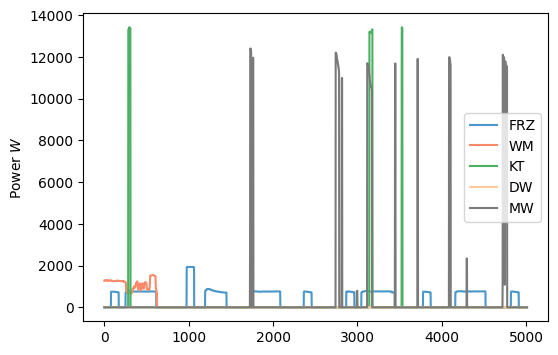

In [53]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dish washer':"DW", 'washer dryer':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(6, 4))
for i, app in enumerate(list(appliance_data.keys())):
    plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
    #plt.plot(y_p_unet[:,2,i]t label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Power $W$")
plt.legend()
plt.savefig("ground_truth", format="pdf")

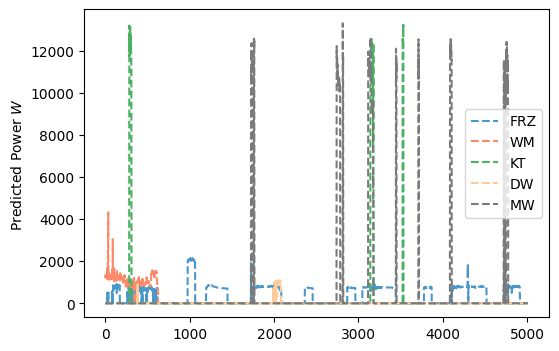

In [54]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dish washer':"DW", 'washer dryer':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(6, 4))
for i, app in enumerate(list(appliance_data.keys())):
    #plt.plot(y_t_cnn[:,i], label=appliance_labels[app], color=colors[i])
    plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Predicted Power $W$")
plt.legend()
plt.savefig("unet_prediction", format="pdf")